## Fake News Classification Project v2.0

In [1]:
# pip install cuml-cu12 --extra-index-url=https://pypi.nvidia.com

Transformers not available — BERT disabled.
cuML detected — GPU acceleration enabled for classical ML.
EXPLORATORY DATA ANALYSIS
Dataset shape: (44680, 4)

Class distribution:
 is_fake
1    23469
0    21211
Name: count, dtype: int64


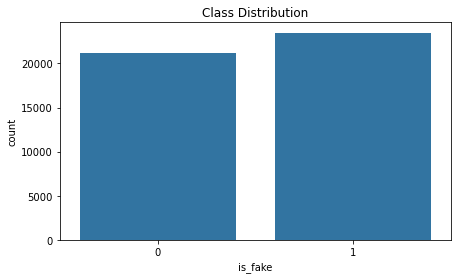


ADVANCED TEXT PREPROCESSING
Cleaning text… (slow step)


KeyboardInterrupt: 

In [2]:
"""
Fake News Classification Project - GPU + tqdm version
====================================================
Complete ML pipeline with GPU acceleration (cuML + CUDA),
tqdm progress bars, robust preprocessing, augmentation,
cross-validation, and optional BERT fine-tuning.
"""

# =========================
# 0. Imports
# =========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud
import random

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

from tqdm.auto import tqdm

# Try PyTorch + Transformers
try:
    import torch
    from transformers import BertTokenizer, BertForSequenceClassification, AdamW
    from torch.utils.data import Dataset, DataLoader
    BERT_AVAILABLE = True
except:
    print("Transformers not available — BERT disabled.")
    BERT_AVAILABLE = False

# Try RAPIDS cuML GPU acceleration
USE_GPU_CLASSICAL = True
try:
    if USE_GPU_CLASSICAL:
        import cuml
        from cuml.feature_extraction.text import TfidfVectorizer as cuTFIDF
        from cuml.linear_model import LogisticRegression as cuLR
        from cuml.ensemble import RandomForestClassifier as cuRF
        import cupy as cp
        CUML_AVAILABLE = True
        print("cuML detected — GPU acceleration enabled for classical ML.")
    else:
        CUML_AVAILABLE = False
except Exception:
    print("cuML NOT available — using CPU scikit-learn.")
    CUML_AVAILABLE = False

import warnings
warnings.filterwarnings('ignore')

# NLTK downloads
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('omw-1.4', quiet=True)

# =========================
# GPU selection (CUDA / MPS / CPU)
# =========================
def get_device():
    if torch.cuda.is_available():
        print("Using CUDA GPU")
        return torch.device("cuda")
    elif getattr(torch.backends, "mps", None) and torch.backends.mps.is_available():
        print("Using Apple MPS GPU")
        return torch.device("mps")
    print("Using CPU")
    return torch.device("cpu")

# =========================
# 1. Load & Explore Data
# =========================
print("="*60)
print("EXPLORATORY DATA ANALYSIS")
print("="*60)

CSV_PATH = '/home/liubov/Téléchargements/fake_news_full_data.csv'
df = pd.read_csv(CSV_PATH)

if 'Unnamed: 0' in df.columns:
    df.drop(columns=['Unnamed: 0'], inplace=True)

print("Dataset shape:", df.shape)
print("\nClass distribution:\n", df['is_fake'].value_counts())

plt.figure(figsize=(7, 4))
sns.countplot(data=df, x='is_fake')
plt.title("Class Distribution")
plt.show()

# =========================
# 2. Robust Advanced Text Preprocessing
# =========================
print("\n" + "="*60)
print("ADVANCED TEXT PREPROCESSING")
print("="*60)

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def safe_pos_tag(words):
    try:
        return pos_tag(words)
    except:
        return [(w, 'N') for w in words]

def get_wordnet_pos(word):
    tag = safe_pos_tag([word])[0][1][0].upper()
    return {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}.get(tag, wordnet.NOUN)

def advanced_preprocess(text):
    if pd.isna(text): return ""
    text = str(text).lower()

    contractions = {
        "won't": "will not", "can't": "cannot", "n't": " not",
        "'re": " are", "'ve": " have", "'ll": " will",
        "'d": " would", "'m": " am"
    }
    for c, e in contractions.items():
        text = text.replace(c, e)

    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"\S+@\S+", "", text)
    text = re.sub(r"[^\w\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()

    tokens = word_tokenize(text)
    clean = []
    for w in tokens:
        if w not in stop_words and len(w) > 2:
            clean.append(lemmatizer.lemmatize(w, get_wordnet_pos(w)))
    return " ".join(clean)

print("Cleaning text… (slow step)")
df['text_clean'] = df['text'].apply(advanced_preprocess)
df['title_clean'] = df['title'].apply(advanced_preprocess)

# =========================
# 3. Data Augmentation
# =========================
print("\n" + "="*60)
print("DATA AUGMENTATION")
print("="*60)

def synonym_replace(text, n=2):
    words = text.split()
    candidates = [w for w in words if wordnet.synsets(w)]
    if not candidates: return text
    random.shuffle(candidates)
    for w in candidates[:n]:
        syn = wordnet.synsets(w)[0].lemmas()[0].name()
        words = [syn if x == w else x for x in words]
    return " ".join(words)

def random_delete(text, p=0.1):
    words = text.split()
    if len(words) <= 1: return text
    kept = [w for w in words if random.random() > p]
    return " ".join(kept) if kept else random.choice(words)

def random_swap(text, n=2):
    words = text.split()
    if len(words) < 2: return text
    words = words[:]
    for _ in range(n):
        a, b = random.sample(range(len(words)), 2)
        words[a], words[b] = words[b], words[a]
    return " ".join(words)

aug_funcs = [synonym_replace, random_delete, random_swap]

minority_class = df['is_fake'].value_counts().idxmin()
minority_df = df[df['is_fake'] == minority_class]

augmented = []
for _, row in minority_df.sample(min(500, len(minority_df))).iterrows():
    f = random.choice(aug_funcs)
    new_text = f(row['text_clean'])
    augmented.append({
        'combined_text': row['title_clean'] + " " + new_text,
        'is_fake': row['is_fake']
    })

aug_df = pd.DataFrame(augmented)

# =========================
# 4. Combine Features
# =========================
df['combined_text'] = df['title_clean'] + " " + df['text_clean']
df_combined = pd.concat([
    df[['combined_text', 'is_fake']],
    aug_df[['combined_text', 'is_fake']]
], ignore_index=True)

print("Dataset after augmentation:", df_combined.shape)

# =========================
# 5. Train-test split
# =========================
X = df_combined['combined_text']
y = df_combined['is_fake']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# =========================
# 6. Baseline
# =========================
baseline = y_train.mode()[0]
y_pred_base = np.full_like(y_test, baseline)
baseline_f1 = f1_score(y_test, y_pred_base)
baseline_acc = accuracy_score(y_test, y_pred_base)

# =========================
# 7. Logistic Regression (GPU/CPU Auto)
# =========================
print("\n" + "="*60)
print("MODEL 2: LOGISTIC REGRESSION (GPU/CPU AUTO)")
print("="*60)

if CUML_AVAILABLE:
    print("Using cuML GPU TF-IDF + Logistic Regression")
    tfidf = cuTFIDF(max_features=5000, ngram_range=(1, 3))
    X_train_tfidf = tfidf.fit_transform(X_train)
    X_test_tfidf = tfidf.transform(X_test)

    lr_model = cuLR(max_iter=1000)
    lr_model.fit(X_train_tfidf, y_train.astype("int32"))

    y_pred_lr = lr_model.predict(X_test_tfidf).get()
    lr_f1 = f1_score(y_test, y_pred_lr)
    lr_acc = accuracy_score(y_test, y_pred_lr)

else:
    print("Using CPU TF-IDF + GridSearchCV Logistic Regression")
    tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 3))
    X_train_tfidf = tfidf.fit_transform(X_train)
    X_test_tfidf = tfidf.transform(X_test)

    lr = GridSearchCV(
        estimator=LogisticRegression(max_iter=1000),
        param_grid={
            'C': [0.1, 1, 10],
            'penalty': ['l2'],
            'solver': ['liblinear', 'saga']
        },
        scoring='f1',
        cv=3
    )
    lr.fit(X_train_tfidf, y_train)
    y_pred_lr = lr.predict(X_test_tfidf)

    lr_f1 = f1_score(y_test, y_pred_lr)
    lr_acc = accuracy_score(y_test, y_pred_lr)

# =========================
# 8. Random Forest (GPU/CPU Auto)
# =========================
print("\n" + "="*60)
print("MODEL 3: RANDOM FOREST (GPU/CPU AUTO)")
print("="*60)

if CUML_AVAILABLE:
    print("Using cuML GPU Random Forest")
    cv = CountVectorizer(max_features=5000)
    X_train_cv = cv.fit_transform(X_train)
    X_test_cv = cv.transform(X_test)

    X_train_gpu = cp.sparse.csr_matrix(X_train_cv)
    X_test_gpu = cp.sparse.csr_matrix(X_test_cv)

    rf_model = cuRF(n_estimators=200, max_depth=30)
    rf_model.fit(X_train_gpu, y_train.astype("int32"))

    y_pred_rf = rf_model.predict(X_test_gpu).get()
    rf_f1 = f1_score(y_test, y_pred_rf)
    rf_acc = accuracy_score(y_test, y_pred_rf)

else:
    print("Using CPU Random Forest")
    from sklearn.ensemble import RandomForestClassifier
    rf = RandomForestClassifier(n_estimators=200, max_depth=30, class_weight="balanced")
    rf.fit(X_train_cv, y_train)
    y_pred_rf = rf.predict(X_test_cv)
    rf_f1 = f1_score(y_test, y_pred_rf)
    rf_acc = accuracy_score(y_test, y_pred_rf)

# =========================
# 9–10: Gradient Boosting + Ensemble (CPU)
# =========================
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier

gb = GradientBoostingClassifier()
gb.fit(X_train_tfidf, y_train)
y_pred_gb = gb.predict(X_test_tfidf)
gb_f1 = f1_score(y_test, y_pred_gb)
gb_acc = accuracy_score(y_test, y_pred_gb)

ensemble = VotingClassifier(
    estimators=[
        ('lr', lr_model if CUML_AVAILABLE else lr.best_estimator_),
        ('gb', gb)
    ],
    voting='soft'
)
ensemble.fit(X_train_tfidf, y_train)
y_pred_ensemble = ensemble.predict(X_test_tfidf)
ensemble_f1 = f1_score(y_test, y_pred_ensemble)
ensemble_acc = accuracy_score(y_test, y_pred_ensemble)

# =========================
# 11. tqdm-Based BERT Training
# =========================
if BERT_AVAILABLE:
    print("\n" + "="*60)
    print("MODEL 6: BERT FINE-TUNING")
    print("="*60)

    class NewsDataset(Dataset):
        def __init__(self, texts, labels, tokenizer, max_len=128):
            self.texts = texts
            self.labels = labels
            self.tokenizer = tokenizer
            self.max_len = max_len

        def __len__(self): return len(self.texts)
        def __getitem__(self, idx):
            enc = self.tokenizer.encode_plus(
                self.texts.iloc[idx],
                max_length=self.max_len,
                truncation=True,
                padding="max_length",
                return_tensors="pt"
            )
            return {
                'input_ids': enc['input_ids'].squeeze(),
                'attention_mask': enc['attention_mask'].squeeze(),
                'labels': torch.tensor(self.labels.iloc[idx])
            }

    N = 1000
    X_train_b = X_train.head(N).reset_index(drop=True)
    y_train_b = y_train.head(N).reset_index(drop=True)
    X_test_b = X_test.head(200).reset_index(drop=True)
    y_test_b = y_test.head(200).reset_index(drop=True)

    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

    train_loader = DataLoader(NewsDataset(X_train_b, y_train_b, tokenizer), batch_size=16, shuffle=True)
    test_loader = DataLoader(NewsDataset(X_test_b, y_test_b, tokenizer), batch_size=16)

    device = get_device()
    model.to(device)

    optimizer = AdamW(model.parameters(), lr=2e-5)

    epochs = 2
    for epoch in range(epochs):
        model.train()
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for batch in loop:
            optimizer.zero_grad()

            ids = batch['input_ids'].to(device)
            ms = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            out = model(ids, attention_mask=ms, labels=labels)
            loss = out.loss
            loss.backward()
            optimizer.step()
            loop.set_postfix(loss=float(loss))

    # Evaluation
    model.eval()
    preds = []
    truth = []
    for batch in tqdm(test_loader, desc="Evaluating BERT"):
        ids = batch['input_ids'].to(device)
        ms = batch['attention_mask'].to(device)
        labels = batch['labels']

        with torch.no_grad():
            logits = model(ids, attention_mask=ms).logits

        p = torch.argmax(logits, dim=1).cpu().numpy().tolist()
        preds.extend(p)
        truth.extend(labels.numpy().tolist())

    bert_f1 = f1_score(truth, preds)
    bert_acc = accuracy_score(truth, preds)
else:
    bert_f1 = 0
    bert_acc = 0

# =========================
# 12. Results Table
# =========================
results = pd.DataFrame({
    "Model": [
        "Baseline",
        "Logistic Regression",
        "Random Forest",
        "Gradient Boosting",
        "Ensemble",
        "BERT"
    ],
    "F1-Score": [
        baseline_f1, lr_f1, rf_f1, gb_f1, ensemble_f1, bert_f1
    ],
    "Accuracy": [
        baseline_acc, lr_acc, rf_acc, gb_acc, ensemble_acc, bert_acc
    ]
})

print("\nFINAL RESULTS:\n", results)

# =========================
# 13. Confusion matrix (best model)
# =========================
best_model = results.iloc[results['F1-Score'].idxmax()]
print("\nBest model:", best_model['Model'])

if best_model['Model'] == "Logistic Regression":
    y_pred_best = y_pred_lr
elif best_model['Model'] == "Random Forest":
    y_pred_best = y_pred_rf
elif best_model['Model'] == "Gradient Boosting":
    y_pred_best = y_pred_gb
elif best_model['Model'] == "Ensemble":
    y_pred_best = y_pred_ensemble
else:
    y_pred_best = preds
    y_test_eval = truth

cm = confusion_matrix(y_test if best_model['Model'] != "BERT" else y_test_eval, y_pred_best)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title(f"Confusion Matrix - {best_model['Model']}")
plt.show()

print("\nProject finished successfully.")
